*Copyright (C) 2022-23 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Tutorial 3: Normalization Network

**Motivation:** In this tutorial, we will highlight more of the standard library included with Lava-VA. Here we demonstrate the Normalization network for computing a normalized vector output from a dot product.




In [1]:
from pylab import *

Here again we setup the imports and connect to Loihi 2.

In [2]:
import lava.frameworks.loihi2 as lv

In [3]:
from lava.utils import loihi

loihi.use_slurm_host(loihi_gen=loihi.ChipGeneration.N3B3)
use_loihi2 = loihi.is_installed()

if use_loihi2:
    run_cfg = lv.Loihi2HwCfg()
    print("Running on Loihi 2")
else:
    run_cfg = lv.Loihi2SimCfg(select_tag='fixed_pt')
    print("Loihi2 compiler is not available in this system. "
          "This tutorial will execute on CPU backend.")

Running on Loihi 2


Now we will create some inputs and initialize the weight matrix.

In [4]:
num_steps=20
weights = np.zeros((10,1))

weights[:,0] = [2, 4, -2, -4, 8, 10, -8, -10, 5, -5]
weights /= 10

inp_data = np.zeros((weights.shape[1], num_steps))

inp_data[:, 2] = 160
inp_data[:, 5] = 320
inp_data[:, 8] = 640
inp_data[:, 11] = 1280


In this demo, we set the input stimulus to be of different magnitudes. The inputs will multiply with the weight values, producing a vector output. 

In [5]:
weights

array([[ 0.2],
       [ 0.4],
       [-0.2],
       [-0.4],
       [ 0.8],
       [ 1. ],
       [-0.8],
       [-1. ],
       [ 0.5],
       [-0.5]])

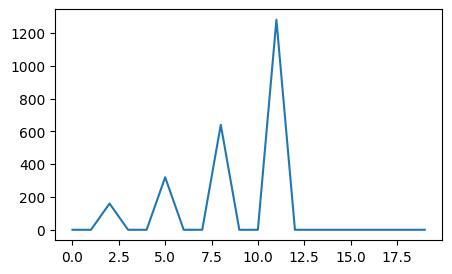

In [6]:
figure(figsize=(5,3))
plot(inp_data.T);

Note, the increasing amplitude of the input values. Also note the exact timesteps of the input stimulus.

Next, we instantiate the objects from the standard library. The NormalizeNet Network object will act like GradedVec, but its outputs will be normalized. This might be useful for various computations, like the cosine similarity.

Under the hood, NormalizeNet uses a feedback inhibition loop to compute the normalization factor. The sum of squares is sent to an "inhibitory neuron", which computes the inverse square root. The inverse square root value is conveyed back to the neuron layer and multiplied with the original input values. The output is then emitted on the primary channel, which is a normalized result of the dot product computation.

Note: because the network receives a recurrent inhibition, each stage takes a timestep. This means that the output is delayed by two timesteps.

In [7]:
invec = lv.InputVec(inp_data, loihi2=use_loihi2)
in_w = lv.GradedDense(weights=weights)
norm_layer = lv.NormalizeNet(shape=(weights.shape[0],))
monitor = lv.OutputVec(shape=(weights.shape[0],), 
                       buffer=num_steps,
                       loihi2=use_loihi2)

In [8]:
norm_layer << in_w @ invec
monitor << norm_layer

In [9]:
try:
    norm_layer.run(condition=lv.RunSteps(num_steps=num_steps),
                   run_cfg=run_cfg)
    out_data = monitor.get_data()
finally:
    norm_layer.stop()

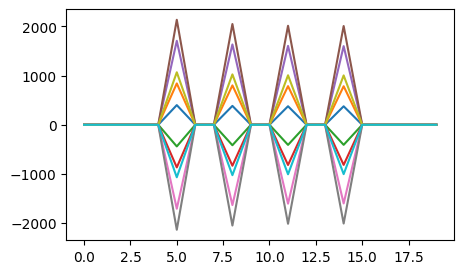

In [10]:
# Normalized output channel
figure(figsize=(5,3))
plot(out_data.T)

This results in the same vector being output, with a consistent total magnitude, regardless of the input magnitude. Notice that there is some slight perturbation due to rounding and some approximations with the fixed point square root algorithm. 
